In [1]:
from os import listdir
from numpy import asarray
from numpy import vstack
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import savez_compressed
from numpy.random import randint
from tensorflow.keras.models import load_model

import os
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from keras.models import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout
from matplotlib import pyplot

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        #for gpu in gpus:
        #    tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [13]:
def load_images(path1,path2, size=(256,256)):
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename1 in glob.glob(path1+"/*/*.jpg"):
        # load and resize the image
        pixels_1 = load_img(filename1, target_size=size)
        # convert to numpy array
        pixels_1 = img_to_array(pixels_1)
        # split into satellite and map
        src_list.append(pixels_1)
        
    for filename2 in glob.glob(path2+"/*/*.jpg"):
        # load and resize the image
        pixels_2 = load_img(filename2, target_size=size)
        # convert to gray scale
        # pixels_2 = pixels_2.convert('L')
        # convert to numpy array
        pixels_2 = img_to_array(pixels_2)
        # convert 16 bits to 8 bits
        # pixels_2= (pixels_2/256).astype('uint8')
        # split into satellite and map
        tar_list.append(pixels_2)
        
    return [asarray(src_list), asarray(tar_list)]

# dataset path
path1 = './RGB_train_final'
path2 = './IR_train_final'
# load dataset
[src_images, tar_images] = load_images(path1,path2)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'train_final.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (8260, 256, 256, 3) (8260, 256, 256, 3)
Saved dataset:  train_final.npz


In [3]:
len(src_images)

5664

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(tar_images[3], interpolation='nearest')
plt.show()

Loaded:  (7080, 256, 256, 3) (7080, 256, 256, 3)


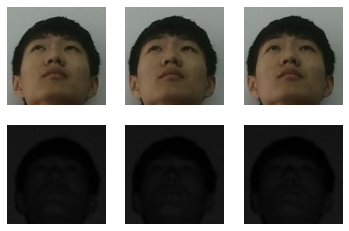

In [4]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('train_data_rgb_ir_crop_7080.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [3]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (2,2), strides=(1,1), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (2,2), strides=(1,1), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (2,2), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (2,2), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [4]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [6]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [7]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [8]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [9]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	# checkpoint_dir = './training_checkpoints_14_14_b_2'
	# checkpoint_name = 'ckpt'
	# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
	# opt = Adam(lr=0.0002, beta_1=0.5)
	# checkpoint = tf.train.Checkpoint(generator_optimizer=opt,
    #                              discriminator_optimizer=opt,
    #                              generator=g_model,
    #                              discriminator=d_model,
	# 							 epoch=tf.Variable(0))
	# checkpoint.save(file_prefix = checkpoint_prefix)
	# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=15,
    #                                  checkpoint_name=checkpoint_name)
	# save_path = manager.save()
	# print("Saved checkpoint for epoch {}: {}".format(step+1, save_path))
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
	# print('>Saved: %s' % filename1)

In [10]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		# print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
			summarize_performance(i, g_model, d_model, dataset)

In [11]:
# load image data
dataset = load_real_samples('train_final_2.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
print(image_shape)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

KeyboardInterrupt: 

In [ ]:
# load image data
dataset = load_real_samples('train_data_rgb_ir_crop_7080.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
print(image_shape)
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
opt = Adam(lr=0.0002, beta_1=0.5)
checkpoint = tf.train.Checkpoint(generator_optimizer=opt,
                                 discriminator_optimizer=opt,
                                 generator=g_model,
                                 discriminator=d_model)
checkpoint.restore('./training_checkpoints_14_14/ckpt-2')
train(d_model, g_model, gan_model, dataset)

Loaded (7080, 256, 256, 3) (7080, 256, 256, 3)
(256, 256, 3)


/home/gary/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>70800, d1[0.000] d2[0.001] g[6.769]
Saved checkpoint for epoch 70800: ./training_checkpoints_7_7/ckpt-2
>Saved: plot_070800.png
>141600, d1[0.001] d2[0.003] g[5.876]
Saved checkpoint for epoch 141600: ./training_checkpoints_7_7/ckpt-2
>Saved: plot_141600.png
>212400, d1[0.000] d2[0.001] g[7.990]
Saved checkpoint for epoch 212400: ./training_checkpoints_7_7/ckpt-2
>Saved: plot_212400.png
>283200, d1[0.190] d2[0.105] g[5.005]
Saved checkpoint for epoch 283200: ./training_checkpoints_7_7/ckpt-2
>Saved: plot_283200.png
>354000, d1[0.002] d2[0.006] g[5.447]
Saved checkpoint for epoch 354000: ./training_checkpoints_7_7/ckpt-2
>Saved: plot_354000.png
>424800, d1[0.002] d2[0.002] g[6.363]
Saved checkpoint for epoch 424800: ./training_checkpoints_7_7/ckpt-2
>Saved: plot_424800.png
>495600, d1[0.006] d2[0.008] g[5.500]
Saved checkpoint for epoch 495600: ./training_checkpoints_7_7/ckpt-2
>Saved: plot_495600.png
>566400, d1[0.004] d2[0.008] g[5.233]
Saved checkpoint for epoch 566400: ./training_c

Loaded (4012, 256, 256, 3) (4012, 256, 256, 3)
[2170]


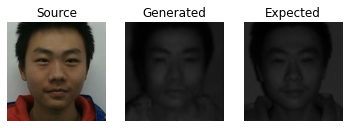

In [21]:
[X1, X2] = load_real_samples('test_final.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('./2_24/model_1189440.h5')
image_shape = X1.shape[1:]
# d_model = define_discriminator(image_shape)
# g_model = define_generator(image_shape)
# define the composite model
# gan_model = define_gan(g_model, d_model, image_shape)
# opt = Adam(lr=0.0002, beta_1=0.5)
# checkpoint = tf.train.Checkpoint(generator_optimizer=opt,
#                                  discriminator_optimizer=opt,
#                                  generator=g_model,
#                                  discriminator=d_model)
# checkpoint.restore('./training_checkpoints_14_14_b_2/ckpt-2')

def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()


# ix = randint(0, len(X1), 1)
ix = [2170]
print(ix)
src_image, tar_image = X1[ix], X2[ix]
gen_image = model.predict(src_image)
# gen_image = g_model.predict(src_image)

plot_images(src_image, gen_image, tar_image)

In [11]:
[X1, X2] = load_real_samples('test_final.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_1486800.h5')
image_shape = X1.shape[1:]
# d_model = define_discriminator(image_shape)
# g_model = define_generator(image_shape)
# define the composite model
# gan_model = define_gan(g_model, d_model, image_shape)
# opt = Adam(lr=0.0002, beta_1=0.5)
# checkpoint = tf.train.Checkpoint(generator_optimizer=opt,
#                                  discriminator_optimizer=opt,
#                                  generator=g_model,
#                                  discriminator=d_model)
# checkpoint.restore('./training_checkpoints_14_14_b_2/ckpt-2')

def plot_images(src_img, gen_img, tar_img, idx):
	my_dpi=144
	pyplot.figure(figsize=(256/my_dpi, 256/my_dpi), dpi=my_dpi)
	for i in range(len(gen_img)):
		gen_img = (gen_img + 1) / 2.0
		# print(gen_img.shape)
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(gen_img[i])
		# pyplot.show()
	filename1 = '/home/gary/CV_lab_face_team/2_24_MSE/{}g.png'.format(idx)
	pyplot.savefig(filename1, dpi=my_dpi)


	my_dpi=144
	pyplot.figure(figsize=(256/my_dpi, 256/my_dpi), dpi=my_dpi)
	for i in range(len(tar_img)):
		tar_img = (tar_img + 1) / 2.0
		# print(tar_img.shape)
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(tar_img[i])
		# pyplot.show()
	filename1 = '/home/gary/CV_lab_face_team/2_24_MSE/{}t.png'.format(idx)
	pyplot.savefig(filename1, dpi=my_dpi)


# ix = randint(0, len(X1), 1)
# ix = [5663]

# for i in range(len(X1)):
# 	print(i)
# 	src_image, tar_image = X1[[i]], X2[[i]]
# 	gen_image = model.predict(src_image)
#     # gen_image = g_model.predict(src_image)

# 	plot_images(src_image, gen_image, tar_image, i)

Loaded (4012, 256, 256, 3) (4012, 256, 256, 3)


In [14]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/1_29_MSE/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/1_29_MSE/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  38.1522483753844


In [15]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_1_MSE/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_1_MSE/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  38.14118281955319


In [16]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_5_MSE/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_5_MSE/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  37.16722635585264


In [12]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_14_MSE_10_10/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_14_MSE_10_10/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  46.10965924629059


In [12]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_14_MSE_30_30/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_14_MSE_30_30/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  48.06042331633434


In [13]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_14_MSE_7_7/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_14_MSE_7_7/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  46.36285668902714


In [12]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_14_MSE_14_14/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_14_MSE_14_14/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  44.43306497388128


In [12]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_16_MSE/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_16_MSE/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  36.576518524362676


In [12]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_21_MSE/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_21_MSE/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  28.992907320316096


In [13]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_24_MSE/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_24_MSE/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  26.353059092325452


In [12]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_24_MSE_2/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_24_MSE_2/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  25.576752511478002


In [13]:
import numpy as np
import cv2

MSE = 0
for i in range(len(X1)):
    img1 = cv2.imread('/home/gary/CV_lab_face_team/2_24_MSE_3/{}t.png'.format(i))
    img2 = cv2.imread('/home/gary/CV_lab_face_team/2_24_MSE_3/{}g.png'.format(i))
    mse = np.square(np.subtract(img1, img2)).mean()
    MSE = MSE + mse
MSE = MSE / len(X1)
print("MSE: ", MSE)


MSE:  24.89066759681894
